In [10]:
import torch
import torchvision
from torchvision.datasets import STL10
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import torch.optim as optim
import cv2

In [11]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
from sklearn import svm
from sklearn.metrics import classification_report
import seaborn as sns
import os
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


# 1. [400 Level, Implement 1.a only and 1.b is bonus]
# Download a ResNet 50 trained on the ImageNet classification dataset,
# a) Use the features extracted from the last fully-connected layer and train a
# multiclass SVM classifier on STL-10 dataset. Report the following [20 marks]

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

Using cache found in /home/moonlab/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
resnet50.eval().to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
img_transform=transforms.Compose([
      transforms.ToTensor()
])

In [ ]:
train_dataset=STL10("/media/storage/data",transform=img_transform,split="train",download=True)
test_dataset=STL10("/media/storage/data",transform=img_transform,split="test",download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size=100
train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_dl=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
data=iter(train_dl)
img,labels=data.next()

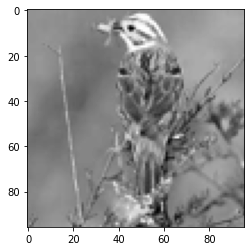

In [ ]:
plt.imshow(img[0][0],cmap="gray")

In [ ]:
img[0].shape

torch.Size([3, 96, 96])

In [ ]:
svm_features=[]
svm_labels=[]
data=iter(train_dl)

try:
    while True:
        img,labels=data.next()
        for i in img:
            svm_features.extend(resnet50(torch.Tensor(i).reshape(1,3,96,96)).detach().numpy())
        svm_labels.extend(labels.detach().numpy())
except:
    pass

In [ ]:
len(svm_features),len(svm_labels)

(5000, 5000)

In [ ]:
clf = svm.SVC(decision_function_shape='ovr')
clf.fit(svm_features, svm_labels)

SVC()

In [ ]:
print(classification_report(svm_labels,clf.predict(svm_features))) #training

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       500
           1       1.00      0.99      0.99       500
           2       0.99      0.99      0.99       500
           3       0.97      0.97      0.97       500
           4       0.96      0.98      0.97       500
           5       0.98      0.97      0.98       500
           6       0.98      0.97      0.97       500
           7       0.99      0.99      0.99       500
           8       0.95      0.99      0.97       500
           9       0.98      0.97      0.98       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [ ]:
def confusion_matrix(y_true,y_pred,n_classes):
    cm=np.zeros(shape=(n_classes,n_classes))
    for i in range(len(y_pred)):
        cm[y_true[i]][y_pred[i]]+=1.0
    return cm

In [ ]:
def accuracy(y_true,y_pred):
    total=0.0
    correct=0.0
    for i in range(len(y_pred)):
        if y_pred[i]==y_true[i]:
            correct+=1.0
        total+=1.0
    return correct/total

In [ ]:
def roc_curve(y_pred,y_true,classs):
    tp_rate=[]
    fp_rate=[]
    tp,fp,tn,fn=0,0,1e-31,1e-31
    for i in range(len(y_pred)):
        if y_pred[i]==classs:
            if y_pred[i]==y_true[i]:
                tp+=1.0
            else:
                fp+=1.0
        else:
            if y_true==classs:
                fn+=1.0
            else:
                tn+=1.0
        tp_rate.append(tp/(tp+fn))
        fp_rate.append(fp/(fp+tn))
    return tp_rate,fp_rate

In [ ]:
test_svm_features=[]
test_svm_labels=[]
data=iter(test_dl)

try:
    while True:
        img,labels=data.next()
        for i in img:
            test_svm_features.extend(resnet50(torch.Tensor(i).reshape(1,3,96,96)).detach().numpy())
        test_svm_labels.extend(labels.detach().numpy())
except:
    pass

# i. Accuracy, Confusion Matrix on test data. [15 marks]

In [ ]:
prediction=clf.predict(test_svm_features)
cm=confusion_matrix(test_svm_labels,prediction,10)

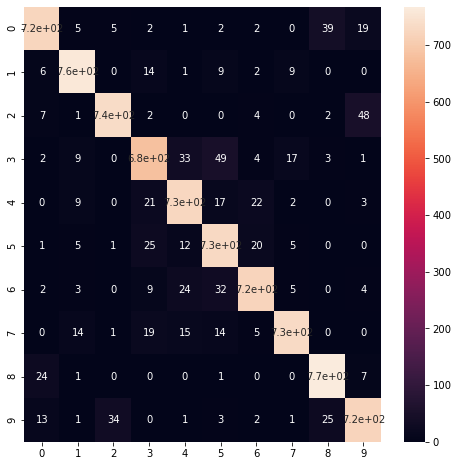

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.show()

In [ ]:
accuracy(test_svm_labels,prediction)

0.912375

# ii. ROC curve (assuming the chosen class as positive class and
# remaining classes as negative) [15 marks]

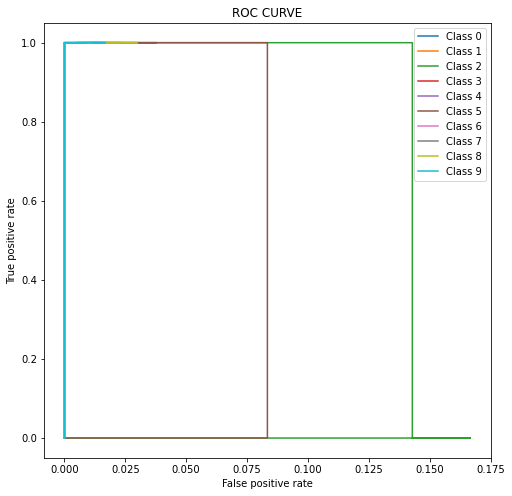

In [ ]:
plt.figure(figsize=(8,8))
for i in range(10):
    y,x=roc_curve(prediction,test_svm_labels,i)
    plt.plot(x,y,label="Class "+str(i))
plt.legend()
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC CURVE")
plt.show()

# 2. [400 Level and 700 Level]
# Download Tiny ImageNet dataset from here. Finetune Densenet 121 [20 Marks for Densenet code and data I/O] with the following.

In [2]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 152.9 MB 22 kB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch

In [3]:
import torch_xla
import torch_xla.core.xla_model as xm

In [4]:
device = xm.xla_device()

In [5]:
device

device(type='xla', index=1)

In [6]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-04-11 04:52:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  55.9MB/s    in 6.4s    

2022-04-11 04:52:10 (36.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [7]:
!unzip tiny-imagenet-200.zip;

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [8]:
train_dir="/content/tiny-imagenet-200/train"

In [12]:
os.listdir(train_dir)[1:10]

['n02795169',
 'n03388043',
 'n03980874',
 'n02909870',
 'n02815834',
 'n02415577',
 'n02395406',
 'n02410509',
 'n01882714']

In [38]:
class DENSENET_FINETUNE(nn.Module):
    def __init__(self,num_classes):
        super(DENSENET_FINETUNE,self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        for param in self.model.parameters():
          param.requires_grad=False
        self.model.features.denseblock4.denselayer14.requires_grad_=True  
        self.model.features.denseblock4.denselayer15.requires_grad_=True
        self.model.features.denseblock4.denselayer16.requires_grad_=True
        self.model.features.norm5.requires_grad_=True
        self.model.classifier.requires_grad=True
        self.model.classifier = nn.Linear(1024, num_classes)
    def forward(self,x):
        out=self.model(x)
        return out

In [39]:
model=DENSENET_FINETUNE(200)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [40]:
for p in model.parameters():
  if p.requires_grad==True:
    print(p.shape)

torch.Size([200, 1024])
torch.Size([200])


In [ ]:
y=model(torch.randn(10,3,225,225))

In [ ]:
y.shape

torch.Size([10, 200])

In [ ]:
y

tensor([[-1.4915e-01, -8.4906e-01,  9.2537e-02,  ..., -2.9352e-01,
         -9.9553e-02, -2.0546e-01],
        [-6.0908e-02, -7.2044e-01,  3.2383e-01,  ...,  7.1821e-04,
         -1.0425e-01,  2.2606e-02],
        [-2.3862e-01, -8.0308e-01, -2.4946e-01,  ..., -3.1320e-02,
          7.6869e-03,  5.0354e-01],
        ...,
        [-3.0308e-01, -8.4992e-01,  4.6610e-01,  ..., -1.8963e-01,
         -6.7976e-01,  5.4898e-01],
        [-8.6134e-02, -5.9929e-01, -4.8090e-02,  ...,  7.9902e-02,
         -4.6149e-01, -2.4060e-02],
        [ 4.1914e-02, -1.0352e+00,  6.6737e-03,  ..., -4.0230e-01,
         -2.1770e-01,  6.8768e-02]], grad_fn=<AddmmBackward0>)

In [ ]:
train_dir="/content/tiny-imagenet-200/train/"
classes=os.listdir(train_dir)
images=[]
labels=[]
for i in range(len(classes)):
    cur_dir=train_dir+classes[i]+"/images/"
    for img_path in os.listdir(cur_dir):
        cur_img=cur_dir+img_path
        images.append(cur_img)
        labels.append(i)

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images_name,labels_name,transform=None):
        self.images_name=images_name
        self.transform=transform
        self.labels_name=labels_name
    def __len__(self):
        return len(self.images_name)
    def __getitem__(self,i):
        path=self.images_name[i]
        img=Image.open(path)
        img = img.convert('RGB')
        img_transform=self.transform(img)
        return img_transform,int(self.labels_name[i])

In [ ]:
train_data=Dataset(images,labels,transform)

In [ ]:
bs=5000
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
train_data[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
file=open(test_annotations,"r+")
data=file.readlines()

In [ ]:
test_classes=[]
images_names=[]
for i in data:
  w=i.split("\t")
  images_names.append(w[0])
  test_classes.append(classes.index(w[1]))

In [ ]:
test_dir="/content/tiny-imagenet-200/val/images/"
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
test_images=[]
test_labels=[]
for i in range(len(images_names)):
    cur_dir=test_dir+images_names[i]
    test_images.append(cur_dir)

In [ ]:
test_data=Dataset(test_images,test_classes,transform)

In [ ]:
bs=5000
test_loader=DataLoader(dataset=test_data,batch_size=bs,shuffle=True,num_workers=8)

# a. Triplet Loss as the final classification loss function [20 marks]

In [ ]:
train_dir="/content/tiny-imagenet-200/train/"
classes=os.listdir(train_dir)
images=[]
labels=[]
for i in range(len(classes)):
    class_data=[]
    class_labels=[]
    cur_dir=train_dir+classes[i]+"/images/"
    for img_path in os.listdir(cur_dir):
        cur_img=cur_dir+img_path
        class_data.append(cur_img)
        class_labels.append(i)
    images.append(class_data)
    labels.append(class_labels)

In [ ]:
import random
class Dataset_t(torch.utils.data.Dataset):
    def __init__(self,images_name,labels_name,transform=None):
        self.images_name=images_name
        self.transform=transform
        self.labels_name=labels_name
        self.class_name=0

    def __len__(self):
        return 50000

    def __getitem__(self,i):

        class_name=self.class_name

        [anchor_path,positive_path]=random.sample(self.images_name[self.class_name],2)
        negative_classes=[x for x in range(0,200) if x != self.class_name]
        negative_class=random.sample(negative_classes,1)[0]

        negative_path=random.sample(self.images_name[negative_class],1)[0]

        anchor_img=Image.open(anchor_path)
        anchor_img = anchor_img.convert('RGB')
        anchor_img_transform=self.transform(anchor_img)

        negative_img=Image.open(negative_path)
        negative_img = negative_img.convert('RGB')
        negative_img_transform=self.transform(negative_img)

        positive_img=Image.open(positive_path)
        positive_img = positive_img.convert('RGB')
        positive_img_transform=self.transform(positive_img)

        self.class_name+=1
        if self.class_name>199:
          self.class_name=0

        return (anchor_img_transform,positive_img_transform,negative_img_transform) #class_name,class_name,negative_class)

In [ ]:
bs=1666
train_data=Dataset_t(images,labels,transform)
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=3)

In [ ]:
model=DENSENET_FINETUNE(200).to(device)
optimizer=optim.Adam(params=model.parameters(),lr=0.001)
criterion=nn.TripletMarginLoss(margin=1.0, p=2)

epochs=1
for epoch in range(epochs):
    batch=0
    for (anchor_img, positive_img, negative_img) in train_loader:
        anchor_img, positive_img, negative_img=anchor_img.to(device),positive_img.to(device),negative_img.to(device)

        anchor_out=model(anchor_img)
        positive_out=model(positive_img)
        negative_out=model(negative_img)


        loss=criterion(anchor_out,positive_out,negative_out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()

        batch+=1
        if batch==20:
          break
        anchor_img, positive_img, negative_img=anchor_img.detach(),positive_img.detach(),negative_img.detach()
        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 1.589310646057129
Epoch: 1 Batch: 2 Training Loss: 1.5475014448165894
Epoch: 1 Batch: 3 Training Loss: 1.4598686695098877


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 4 Training Loss: 1.4729645252227783


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 5 Training Loss: 1.4227337837219238


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c42cbb0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 1 Batch: 6 Training Loss: 1.321283221244812
Epoch: 1 Batch: 7 Training Loss: 1.3154962062835693
Epoch: 1 Batch: 8 Training Loss: 1.324608564376831
Epoch: 1 Batch: 9 Training Loss: 1.1961135864257812
Epoch: 1 Batch: 10 Training Loss: 1.2108961343765259
Epoch: 1 Batch: 11 Training Loss: 1.1806421279907227
Epoch: 1 Batch: 12 Training Loss: 1.1403021812438965
Epoch: 1 Batch: 13 Training Loss: 1.0612798929214478
Epoch: 1 Batch: 14 Training Loss: 1.1092277765274048
Epoch: 1 Batch: 15 Training Loss: 1.0561844110488892
Epoch: 1 Batch: 16 Training Loss: 1.0643956661224365
Epoch: 1 Batch: 17 Training Loss: 1.0471324920654297
Epoch: 1 Batch: 18 Training Loss: 1.006978154182434
Epoch: 1 Batch: 19 Training Loss: 0.9959336519241333


In [ ]:
torch.save(model.state_dict(), 'tripleloss_checkpoint.pth')

# b. Cross-Entropy as the final classification loss function [10 marks]

In [ ]:
#device="cuda"
model=DENSENET_FINETUNE(200).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion=nn.CrossEntropyLoss()

epochs=1
for epoch in range(epochs):
    batch=0
    for image,label in train_loader:
        image,label=image.to(device),label.to(device)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
        batch+=1
        image,label=image.detach(),label.detach()
        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 5.594775676727295
Epoch: 1 Batch: 2 Training Loss: 5.423710346221924
Epoch: 1 Batch: 3 Training Loss: 5.350572109222412
Epoch: 1 Batch: 4 Training Loss: 5.24753999710083
Epoch: 1 Batch: 5 Training Loss: 5.157971382141113
Epoch: 1 Batch: 6 Training Loss: 5.063900470733643
Epoch: 1 Batch: 7 Training Loss: 4.968999862670898
Epoch: 1 Batch: 8 Training Loss: 4.909599304199219
Epoch: 1 Batch: 9 Training Loss: 4.8304924964904785
Epoch: 1 Batch: 10 Training Loss: 4.693960666656494
Epoch: 1 Batch: 11 Training Loss: 4.632184982299805
Epoch: 1 Batch: 12 Training Loss: 4.538096904754639
Epoch: 1 Batch: 13 Training Loss: 4.488636016845703
Epoch: 1 Batch: 14 Training Loss: 4.431417942047119
Epoch: 1 Batch: 15 Training Loss: 4.338597297668457
Epoch: 1 Batch: 16 Training Loss: 4.268797874450684
Epoch: 1 Batch: 17 Training Loss: 4.235251426696777
Epoch: 1 Batch: 18 Training Loss: 4.165388107299805
Epoch: 1 Batch: 19 Training Loss: 4.083281993865967
Epoch: 1 Batch: 20 Tr

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
model.eval()

DENSENET_FINETUNE(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [ ]:
def test_accuarcy(model,test_loader):
    accuracy=0.0
    total=0.0
    with torch.no_grad():
      for image,label in test_loader:
          image=image.to(device)
          out=model(image)
          acc = ((out.argmax(dim=1) == label).float().sum())
          tot=len(test_loader)
          accuracy+=acc
          total+=len(image)
    print("Accuracy on Testing dataset:",accuracy/total)

In [ ]:
test_accuarcy(model,test_loader)

Accuracy on Testing dataset: tensor(0.2200)


# c. Center loss as the final classification loss function [20 marks]

In [ ]:
def compute_center_loss(features, centers, targets):
    features = features.view(features.size(0), -1)
    target_centers = centers[targets]
    criterion = torch.nn.MSELoss()
    center_loss = criterion(features, target_centers)
    return center_loss

In [ ]:
bs=1000
train_data=Dataset(images,labels,transform)
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
#device="cuda"
model=DENSENET_FINETUNE(200).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion=torch.nn.MSELoss()

centers=[torch.zeros(200) for i in range(200)]
number=[0 for i in range(200)]

epochs=1
for epoch in range(epochs):
    batch=0
    for image,label in train_loader:

        for i in label:
          number[int(i)]+=1.0

        image=image.to(device)
        out=model(image)

        center_loss=0
        for i in range(len(label)):
          target_centers = centers[int(label[i])]
          center_loss += criterion(out, target_centers)
      
        optimizer.zero_grad()
        center_loss.backward(retain_graph=True)
        optimizer.step()

        l=center_loss.item()

        for i in range(len(label)):
          centers[label[i]]=centers[label[i]]+(1/number[label[i]])*(out[i]-centers[label[i]])

        batch+=1
        image=image.detach()

        print("Epoch:",epoch+1,"Batch:",batch,"Training Loss:",l)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch: 1 Batch: 1 Training Loss: 536.0440063476562
Epoch: 1 Batch: 2 Training Loss: 557.6414184570312
Epoch: 1 Batch: 3 Training Loss: 514.5760498046875
Epoch: 1 Batch: 4 Training Loss: 474.3051452636719
Epoch: 1 Batch: 5 Training Loss: 440.8599548339844
Epoch: 1 Batch: 6 Training Loss: 406.16827392578125
Epoch: 1 Batch: 7 Training Loss: 376.3351135253906
Epoch: 1 Batch: 8 Training Loss: 348.0061950683594
Epoch: 1 Batch: 9 Training Loss: 322.1061096191406
Epoch: 1 Batch: 10 Training Loss: 301.707275390625
Epoch: 1 Batch: 11 Training Loss: 283.8541564941406
Epoch: 1 Batch: 12 Training Loss: 266.03350830078125
Epoch: 1 Batch: 13 Training Loss: 248.57452392578125
Epoch: 1 Batch: 14 Training Loss: 234.8320770263672
Epoch: 1 Batch: 15 Training Loss: 223.99217224121094
Epoch: 1 Batch: 16 Training Loss: 211.7350311279297
Epoch: 1 Batch: 17 Training Loss: 200.9176788330078
Epoch: 1 Batch: 18 Training Loss: 190.6800537109375
Epoch: 1 Batch: 19 Training Loss: 180.57943725585938
Epoch: 1 Batch: 2

In [ ]:
torch.save(model.state_dict(), 'center_loss_checkpoint.pth')

# Choose any evaluation metrics (at least 3) and compare the models in a, b and c, comment on which one is better and why? [5+5+5+15 = 30 marks]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
test_classes=[]
images_names=[]
for i in data:
  w=i.split("\t")
  images_names.append(w[0])
  test_classes.append(classes.index(w[1]))

test_dir="/content/tiny-imagenet-200/val/images/"
test_annotations="/content/tiny-imagenet-200/val/val_annotations.txt"
test_images=[]
test_labels=[]
for i in range(len(images_names)):
    cur_dir=test_dir+images_names[i]
    test_images.append(cur_dir)

In [ ]:
triplet_loss_model=torch.load("/content/tripleloss_checkpoint.pth")
center_loss_model=torch.load("/content/center_loss_checkpoint.pth")
cross_entropy_model=torch.load("/content/crossentropy_checkpoint.pth")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(triplet_loss_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [ ]:
model.eval();

In [ ]:
y=model(torch.randn(10,3,225,225))

In [ ]:
bs=5000
test_data=Dataset(test_images,test_classes,transform)
test_loader=DataLoader(dataset=test_data,batch_size=bs,shuffle=True,num_workers=8)

In [ ]:
model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

In [ ]:
output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

In [ ]:
output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)

Text(0.5, 1.0, "Triplet Loss's embeddings's PCA")

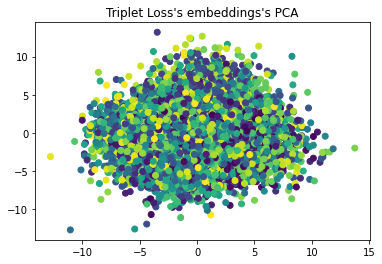

In [ ]:
plt.scatter(pca_out[:,0],pca_out[:,1],c=output_labels_final)
plt.title("Triplet Loss's embeddings's PCA")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(center_loss_model)
model.eval()

model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Text(0.5, 1.0, "Center Loss's embeddings's PCA")

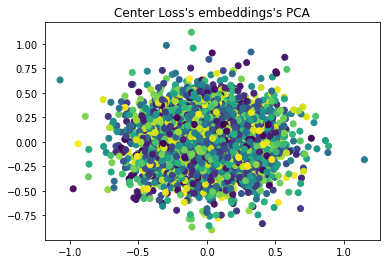

In [ ]:
plt.scatter(pca_out[:,0],pca_out[:,1],c=output_labels_final)
plt.title("Center Loss's embeddings's PCA")

In [ ]:
model=DENSENET_FINETUNE(200)
model.load_state_dict(cross_entropy_model)
model.eval()

model=model.to(device)
output_labels=[]
output_vectors=[]
with torch.no_grad():
  for image,label in test_loader:
    image,label=image.to(device),label.to(device)
    out=model(image)
    image,label=image.detach(),label.detach()
    output_vectors.append(out)
    output_labels.append(label)

output_vectors_final=[]
for i in output_vectors:
  for j in i:
    output_vectors_final.append(j.numpy())
output_vectors_final=np.array(output_vectors_final)

output_labels_final=[]
for i in output_labels:
  for j in i:
    output_labels_final.append(j.numpy())
output_labels_final=np.array(output_labels_final)

pca = PCA(n_components=2)
pca_out=pca.fit_transform(output_vectors_final)



# 3. Implement a three layer CNN network, for classification task for the Dogs vs. Cats dataset.

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2022-04-08 09:07:40--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 49.44.204.142, 2405:200:1630:18bc::e59, 2405:200:1630:18b7::e59
Connecting to download.microsoft.com (download.microsoft.com)|49.44.204.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.1’

kagglecatsanddogs_3 100%[===================>] 786.68M  37.3MB/s    in 17s     

2022-04-08 09:07:57 (46.5 MB/s) - ‘kagglecatsanddogs_3367a.zip.1’ saved [824894548/824894548]



In [ ]:
!unzip kagglecatsanddogs_3367a.zip.1

Archive:  kagglecatsanddogs_3367a.zip.1
   creating: PetImages/Cat/
  inflating: PetImages/Cat/0.jpg     
  inflating: PetImages/Cat/1.jpg     
  inflating: PetImages/Cat/10.jpg    
  inflating: PetImages/Cat/100.jpg   
  inflating: PetImages/Cat/1000.jpg  
  inflating: PetImages/Cat/10000.jpg  
  inflating: PetImages/Cat/10001.jpg  
  inflating: PetImages/Cat/10002.jpg  
  inflating: PetImages/Cat/10003.jpg  
  inflating: PetImages/Cat/10004.jpg  
  inflating: PetImages/Cat/10005.jpg  
  inflating: PetImages/Cat/10006.jpg  
  inflating: PetImages/Cat/10007.jpg  
  inflating: PetImages/Cat/10008.jpg  
  inflating: PetImages/Cat/10009.jpg  
  inflating: PetImages/Cat/1001.jpg  
  inflating: PetImages/Cat/10010.jpg  
  inflating: PetImages/Cat/10011.jpg  
  inflating: PetImages/Cat/10012.jpg  
  inflating: PetImages/Cat/10013.jpg  
  inflating: PetImages/Cat/10014.jpg  
  inflating: PetImages/Cat/10015.jpg  
  inflating: PetImages/Cat/10016.jpg  
  inflating: PetImages/Cat/10017.jpg  
  

In [ ]:
cat_images=os.listdir("/media/storage/data/moonlab/OFFSEG/PetImages/Cat")
dog_images=os.listdir("/media/storage/data/moonlab/OFFSEG/PetImages/Dog")

In [ ]:
len(cat_images),len(dog_images)

(12501, 12501)

In [ ]:
int(12501*0.7)

8750

In [ ]:
x_train=[]
y_train=[]
for i in range(8750):
    x_train.append("Cat/"+cat_images[i])
    x_train.append("Dog/"+dog_images[i])
    y_train.append(0)
    y_train.append(1)
    
x_test=[]
y_test=[]
for i in range(8751,len(cat_images)):
    x_test.append("Cat/"+cat_images[i])
    x_test.append("Dog/"+dog_images[i])
    y_test.append(0)
    y_test.append(1)

In [ ]:
len(x_train),len(y_train),len(x_test),len(y_test)

(17500, 17500, 7500, 7500)

In [ ]:
#x_train.index("Cat/666.jpg")
x_train.index("Dog/11702.jpg")

17173

In [ ]:
del x_train[1456]
del y_train[1456]

In [ ]:
del x_train[17172]
del y_train[17172]

In [ ]:
data_dir="/media/storage/data/moonlab/OFFSEG/PetImages/"

In [ ]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images_name,labels_name,transform=None):
        self.images_name=images_name
        self.transform=transform
        self.labels_name=labels_name
    def __len__(self):
        return len(self.images_name)
    def __getitem__(self,i):
        path=data_dir+self.images_name[i]
        img=Image.open(path)
        img = img.convert('RGB')
        img_transform=self.transform(img)
        return img_transform,self.labels_name[i]

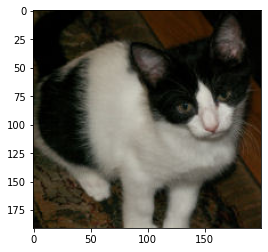

In [ ]:
plt.imshow(plt.imread(data_dir+x_train[0]))

In [ ]:
train_data=Dataset(x_train,y_train,transform)
test_data=Dataset(x_test,y_test,transform)

In [ ]:
bs=1000

In [ ]:
train_loader=DataLoader(dataset=train_data,batch_size=bs,shuffle=False)
test_loader=DataLoader(dataset=test_data,batch_size=bs,shuffle=False)

In [ ]:
len(train_data)

17498

In [ ]:
train_data[11][0].shape

torch.Size([3, 224, 224])

In [ ]:
class CNN_MODEL(nn.Module):
    def __init__(self):
        super(CNN_MODEL,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(3,16,3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(16,32,3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        self.layer3=nn.Sequential(
            nn.Conv2d(32,64,3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fcn=nn.Sequential(
            nn.Flatten(1),
            nn.Linear(576,20),
            nn.Dropout(0.2),
            nn.Linear(20,2),
            nn.ReLU()        
        )
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.fcn(out)
        return out

In [ ]:
def test_accuarcy(model,test_loader):
    accuracy=0.0
    total=0.0
    for image,label in train_loader:
        #print(image.shape)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
        acc = ((out.argmax(dim=1) == label).float().sum())
        tot=len(test_loader)
        accuracy+=acc
        total+=tot
    print("Accuracy on Testing dataset:",accuracy/total)

In [ ]:
train_data[11][0].shape

torch.Size([3, 224, 224])

In [ ]:
device="cpu"

# i. Vanilla SGD

In [ ]:
vanilla_train_loader=DataLoader(dataset=train_data,batch_size=17500,shuffle=False)
vanilla_test_loader=DataLoader(dataset=test_data,batch_size=50,shuffle=False)

model=CNN_MODEL()
optimizer=optim.SGD(params=model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

epochs=10
for epoch in range(epochs):
    for image,label in vanilla_train_loader:
        #print(image.shape)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
    print("Epoch:",epoch+1,"Training Loss:",l)
    
test_accuarcy(model,test_loader)

# ii. Mini Batch SGD

In [ ]:
model=CNN_MODEL()

In [ ]:
optimizer=optim.SGD(params=model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

In [ ]:
epochs=10
for epoch in range(epochs):
    for image,label in train_loader:
        #print(image.shape)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
    print("Epoch:",epoch+1,"Training Loss:",l)

Epoch: 1 Training Loss: 0.7154121398925781
Epoch: 2 Training Loss: 0.718104898929596
Epoch: 3 Training Loss: 0.7072060108184814
Epoch: 4 Training Loss: 0.7009573578834534
Epoch: 5 Training Loss: 0.7037319540977478
Epoch: 6 Training Loss: 0.7004985213279724
Epoch: 7 Training Loss: 0.6961123943328857
Epoch: 8 Training Loss: 0.7040275931358337
Epoch: 9 Training Loss: 0.6962413191795349
Epoch: 10 Training Loss: 0.6892676949501038


In [ ]:
test_accuarcy(model,test_loader)

Accuracy on Testing dataset: tensor(67.6528)


# iii. Mini Batch with momentum

In [ ]:
model=CNN_MODEL()
optimizer=optim.SGD(params=model.parameters(),lr=0.001,momentum=0.9)
criterion=nn.CrossEntropyLoss()

epochs=10
for epoch in range(epochs):
    for image,label in train_loader:
        #print(image.shape)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
    print("Epoch:",epoch+1,"Training Loss:",l)
    
test_accuarcy(model,test_loader)

Epoch: 1 Training Loss: 0.6933841705322266
Epoch: 2 Training Loss: 0.6858420968055725
Epoch: 3 Training Loss: 0.6861527562141418
Epoch: 4 Training Loss: 0.6675206422805786
Epoch: 5 Training Loss: 0.6529415249824524
Epoch: 6 Training Loss: 0.6476748585700989
Epoch: 7 Training Loss: 0.6368875503540039
Epoch: 8 Training Loss: 0.6168322563171387
Epoch: 9 Training Loss: 0.6054786443710327
Epoch: 10 Training Loss: 0.5970977544784546
Accuracy on Testing dataset: tensor(82.7986)


# iv. Mini Batch with Adam

In [ ]:
model=CNN_MODEL()
optimizer=optim.Adam(params=model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

epochs=10
for epoch in range(epochs):
    for image,label in train_loader:
        #print(image.shape)
        out=model(image)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l=loss.item()
    print("Epoch:",epoch+1,"Training Loss:",l)
    
test_accuarcy(model,test_loader)